In [1]:
import pickle
import sys
sys.path.append("/fs/project/PCON0009/Au-scratch2/haoran/_projects/Mili_branch/assign_reads/isoform_quantification")

In [2]:
from TransELS import parse,map_long_reads

In [3]:
# ref_file_path = '/fs/project/PCON0009/Au-scratch2/haoran/reference/genecode/gencode.v38.annotation.gtf'
# READ_LEN = 0
# READ_JUNC_MIN_MAP_LEN = 1
# short_read_alignment_file_path = None
# threads =1
# _,gene_points_dict,gene_isoforms_dict,\
#         SR_gene_regions_dict,SR_genes_regions_len_dict,LR_gene_regions_dict,LR_genes_regions_len_dict,\
#             gene_isoforms_length_dict,raw_isoform_exons_dict,_,\
#                 same_structure_isoform_dict,removed_gene_isoform_dict,gene_range,gene_interval_tree_dict = \
#                     parse(ref_file_path,READ_LEN,READ_JUNC_MIN_MAP_LEN,short_read_alignment_file_path,threads)

In [4]:
# long_read_alignment_file_path = '/fs/ess/scratch/PCON0009/haoran/debug/reads/output.sam'
# filtering = False
# output_path = '/fs/ess/scratch/PCON0009/haoran/debug/reads/quant'
# multi_mapping_filtering = None

In [5]:
# gene_regions_read_mapping = map_long_reads(long_read_alignment_file_path,READ_LEN,READ_JUNC_MIN_MAP_LEN,gene_isoforms_dict,gene_points_dict,gene_range,gene_interval_tree_dict,LR_gene_regions_dict,LR_genes_regions_len_dict,gene_isoforms_length_dict,filtering,\
#                                            output_path,multi_mapping_filtering,threads,raw_isoform_exons_dict)

In [6]:
import re
import pandas as pd
import numpy as np
annotation = '/fs/project/PCON0009/Au-scratch2/haoran/reference/genecode/gencode.v38.annotation.gtf'
from TransELS import parse
import glob

In [7]:
gene_exon_dict = {}
gene_isoform_dict = {}
isoform_exon_dict = {}
strand_dict = {}
with open(annotation,'r') as f:
    for line in f:
        if line.lstrip()[0] == "#":
            continue
        fields = line.split('\t')
        if (fields[2] != 'exon'):
            continue
        strand = fields[6]
        chr_name = fields[0]
        gene_name = re.findall('gene_id "([^"]*)"', fields[8])[0]
        isoform_name = re.findall('transcript_id "([^"]*)"', fields[8])[0]
        start_pos = int(fields[3])
        end_pos = int(fields[4])
        if gene_name not in gene_exon_dict:
            gene_exon_dict[gene_name] = []
            gene_isoform_dict[gene_name] = set()
        if isoform_name not in isoform_exon_dict:
            isoform_exon_dict[isoform_name] = []
        gene_exon_dict[gene_name].append([start_pos,end_pos])
        gene_isoform_dict[gene_name].add(isoform_name)
        isoform_exon_dict[isoform_name].append([start_pos,end_pos])
        strand_dict[gene_name] = strand
for isoform in isoform_exon_dict:
    isoform_exon_dict[isoform] = sorted(isoform_exon_dict[isoform],key=lambda x:(x[0],x[1]))
isoform_len_dict = {}
for isoform in isoform_exon_dict:
    isoform_len_dict[isoform] = 0
    for exon in isoform_exon_dict[isoform]:
        isoform_len_dict[isoform] += exon[1] - exon[0] + 1
singleton_genes = set()
for gname in gene_isoform_dict:
    if len(gene_isoform_dict[gname]) == 1:
        singleton_genes.add(gname)

In [8]:
from sklearn.neighbors import KernelDensity
def kde3d(x, y,z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    xyz = np.vstack([x, y,z])
    d = xyz.shape[0]
    n = xyz.shape[1]
    bw = (n * (d + 2) / 4.) ** (-1. / (d + 4))  # silverman
    kde_3d = KernelDensity(bandwidth=bw).fit(xyz.T)

    return kde_3d

In [9]:
def get_singleton_gene_dist(gene_regions_read_mapping,singleton_genes):
    singleton_genes_dist = []
    for rname in gene_regions_read_mapping:
        for gname in gene_regions_read_mapping[rname]:
            if gname in singleton_genes:
                for region in gene_regions_read_mapping[rname][gname]:
                    for read_mapping in gene_regions_read_mapping[rname][gname][region]:
                        read_start,read_end = read_mapping['read_pos']
                        isoform = next(iter(gene_isoform_dict[gname]))
                        isoform_len = isoform_len_dict[isoform]
                        assert len(gene_isoform_dict[gene_name]) == 1
                        start_offset = 0
                        for [exon_start,exon_end] in isoform_exon_dict[isoform]:
                            if exon_end > read_start:
                                start_offset += read_start - exon_start + 1
                                break
                            else:
                                start_offset += exon_end - exon_start + 1
                        end_offset = isoform_len_dict[isoform] - start_offset - read_mapping['read_length']
                        if start_offset < 0:
                            start_offset = 0
                        if end_offset < 0:
                            end_offset = 0
                        if strand_dict[gname]  == '+':
                            singleton_genes_dist.append([isoform_len,start_offset,end_offset])
                        else:
                            singleton_genes_dist.append([isoform_len,end_offset,start_offset])
    return singleton_genes_dist
        


In [10]:
def get_multi_isoform_dist(gene_regions_read_mapping,LR_gene_regions_dict,singleton_genes):
    multi_isoform_genes_dist = []
    for rname in gene_regions_read_mapping:
        for gname in gene_regions_read_mapping[rname]:
            if gname not in singleton_genes:
                for region in gene_regions_read_mapping[rname][gname]:
                    if len(gene_regions_read_mapping[rname][gname][region]) == 0:
                        continue
                    if len(LR_gene_regions_dict[rname][gname][region]) == 1:
                        isoform = next(iter(LR_gene_regions_dict[rname][gname][region]))
                        if '-' in isoform:
                            continue
                        isoform_len = isoform_len_dict[isoform]
                        for read_mapping in gene_regions_read_mapping[rname][gname][region]:
                            read_start,read_end = read_mapping['read_pos']
                            start_offset = 0
                            for [exon_start,exon_end] in isoform_exon_dict[isoform]:
                                if exon_end > read_start:
                                    start_offset += read_start - exon_start + 1
                                    break
                                else:
                                    start_offset += exon_end - exon_start + 1
                            end_offset = isoform_len_dict[isoform] - start_offset - read_mapping['read_length']
                            if start_offset < 0:
                                start_offset = 0
                            if end_offset < 0:
                                end_offset = 0
                            if strand_dict[gname]  == '+':
                                multi_isoform_genes_dist.append([isoform_len,start_offset,end_offset])
                            else:
                                multi_isoform_genes_dist.append([isoform_len,end_offset,start_offset])
    return multi_isoform_genes_dist

In [11]:
fpath = '/fs/ess/scratch/PCON0009/haoran/debug/reads/quant/dict.pkl'
with open(fpath,'rb') as f:
    [gene_regions_read_mapping,_,LR_gene_regions_dict,_,_]= pickle.load(f)
    singleton_genes_dist = get_singleton_gene_dist(gene_regions_read_mapping,singleton_genes)
    multi_isoform_genes_dist = get_multi_isoform_dist(gene_regions_read_mapping,LR_gene_regions_dict,singleton_genes)


In [15]:
import matplotlib.pyplot as plt

In [76]:
dRNA_dist_df.loc[dRNA_dist_df['Isoform_len'] > 3000,'Isoform_len'].value_counts()

3228    53
3765    52
3794    46
5012    29
3020    26
        ..
3875     1
5922     1
3865     1
3863     1
6143     1
Name: Isoform_len, Length: 1339, dtype: int64

In [61]:
dRNA_dist_df = pd.DataFrame(singleton_genes_dist+multi_isoform_genes_dist)
dRNA_dist_df.columns = ['Isoform_len','5_end_distance','3_end_distance']


In [45]:
with open('/fs/project/PCON0009/Au-scratch2/haoran/_notebooks/singleton_analysis/all_samples/temp/all_dist.pkl','rb') as f:
    dist_arr_dict = pickle.load(f)
dRNA_dist_lst = []
for name,dist_lst in dist_arr_dict.items():
    if 'dRNA' in name:
        dRNA_dist_lst += dist_lst
dRNA_dist_arr = np.array(dRNA_dist_lst)

In [63]:
real_data_dRNA_dist_df = pd.DataFrame(dRNA_dist_arr)
real_data_dRNA_dist_df.columns = ['Isoform_len','5_end_distance','3_end_distance']

In [65]:
selected_isoform_len = 462

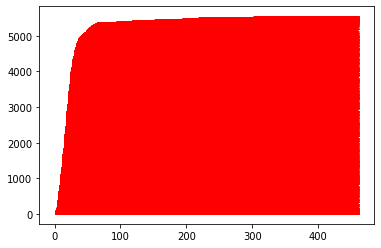

In [66]:
plot_sim_dist_df = dRNA_dist_df[dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_sim_dist_df = plot_sim_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_sim_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

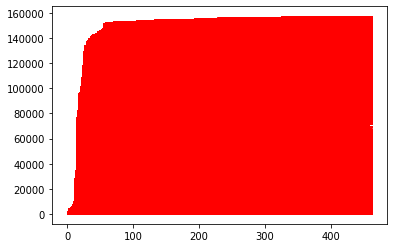

In [64]:
plot_real_dist_df = real_data_dRNA_dist_df[real_data_dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_real_dist_df = plot_real_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_real_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

In [67]:
selected_isoform_len = 943

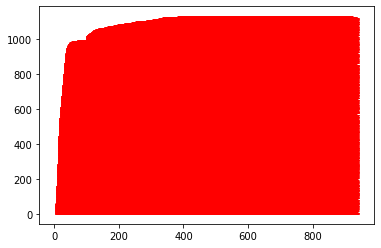

In [68]:
plot_sim_dist_df = dRNA_dist_df[dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_sim_dist_df = plot_sim_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_sim_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

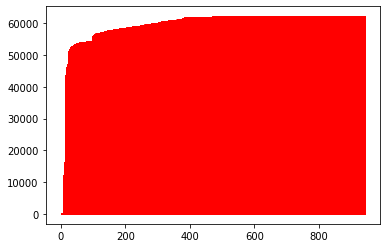

In [69]:
plot_real_dist_df = real_data_dRNA_dist_df[real_data_dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_real_dist_df = plot_real_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_real_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

In [70]:
selected_isoform_len = 1542

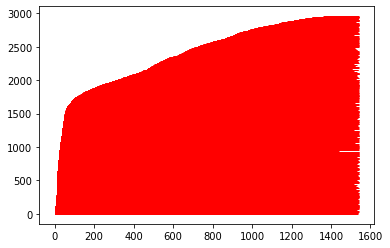

In [71]:
plot_sim_dist_df = dRNA_dist_df[dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_sim_dist_df = plot_sim_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_sim_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

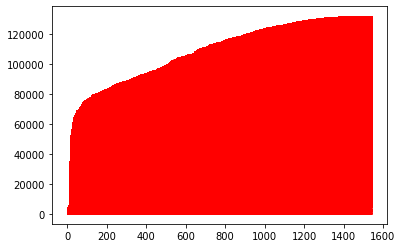

In [72]:
plot_real_dist_df = real_data_dRNA_dist_df[real_data_dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_real_dist_df = plot_real_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_real_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

In [77]:
selected_isoform_len = 3228

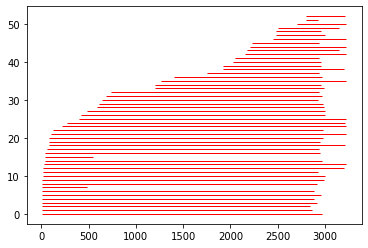

In [78]:
plot_sim_dist_df = dRNA_dist_df[dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_sim_dist_df = plot_sim_dist_df.sort_values(by='5_end_distance')
fig,ax = plt.subplots()
ct = 0
for _,row in plot_sim_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1

In [85]:
plot_real_dist_df = real_data_dRNA_dist_df[real_data_dRNA_dist_df['Isoform_len'] == selected_isoform_len]
plot_real_dist_df = plot_real_dist_df.sample(n=500, random_state=1).sort_values(by='5_end_distance')

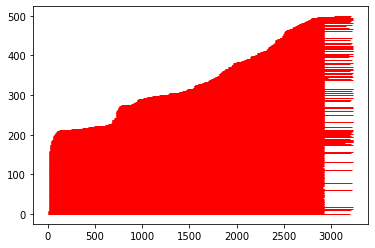

In [86]:
fig,ax = plt.subplots()
ct = 0
for _,row in plot_real_dist_df.iterrows():
    ax.hlines(y=ct, xmin=row['5_end_distance'], xmax= row['Isoform_len'] - row['3_end_distance'], linewidth=1, color='r')
    ct += 1